In [1]:
import matplotlib.pyplot as plt

# Bloodmoon Cookbook

## Loading mask data



In [2]:
from bloodmoon import camera

wfm = camera("wfm_mask.fits")

A camera represents a coded mask instruments and comes with attributes for fetching data from the mask itself, the decoder, the bulk and its balancing array.

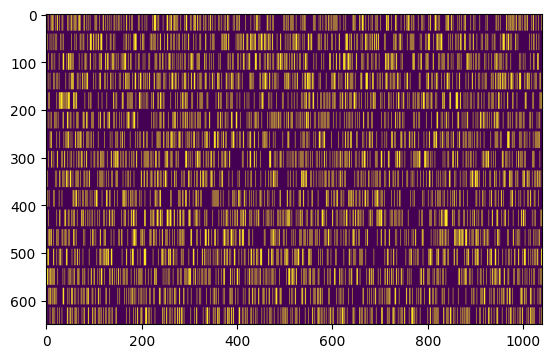

In [3]:
plt.imshow(wfm.mask); plt.show()

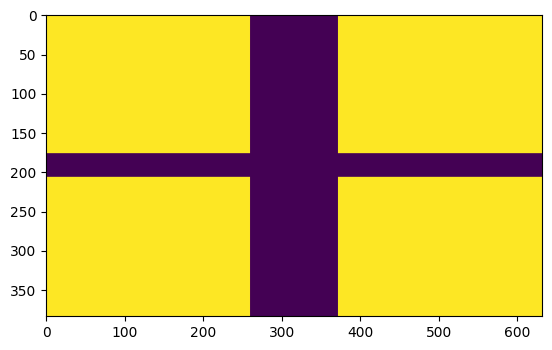

In [4]:
plt.imshow(wfm.bulk); plt.show()

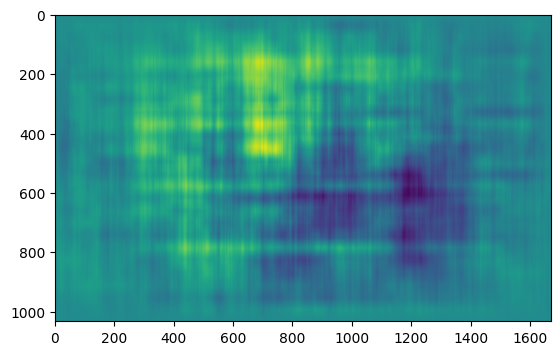

In [5]:
plt.imshow(wfm.balancing); plt.show()

### Mask upscaling

A camera can be defined with an upscaling factor, enhancing its resolution.

In [6]:
wfm_upscaled = camera("wfm_mask.fits", upscale_x=5, upscale_y=8)  # a (5, 8) upscaling results in square mask elements

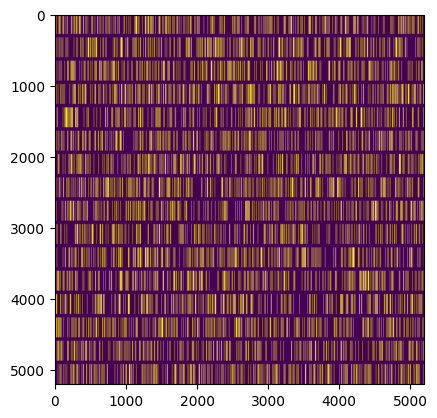

In [7]:
plt.imshow(wfm_upscaled.mask); plt.show()

### Mask parameters

Camera objects hold a number of parameters useful in image reconstruction.

In [8]:
wfm.parameters

{'mask_minx': -130.0,
 'mask_miny': -130.0,
 'mask_maxx': 130.0,
 'mask_maxy': 130.0,
 'mask_deltax': 0.25,
 'mask_deltay': 0.4,
 'mask_thickness': 0.15,
 'slit_deltax': 0.25,
 'slit_deltay': 14.0,
 'detector_minx': -78.988,
 'detector_maxx': 78.988,
 'detector_miny': -76.5255,
 'detector_maxy': 76.5255,
 'mask_detector_distance': 202.9}

## Loading simulation data

Simulations data are stored in a simulation data loader. 

In [9]:
from bloodmoon import simulation

sdl = simulation("../../simulations/id00/")

In particular, a simulation data loader stores, for each simulated camera pair:

1. the photon list before detector reconstruction.
2. the photon list after detector reconstruciton.
3. the photon list tagged with information on the astrophysical sources.
4. pointings data.

For more information on these datasets, refer to Francesco Ceraudo's WISEMAN.

## Detector images

Once we have objects for camera and simulation data loaders, we can construct a detector image.

In [10]:
from bloodmoon import camera, simulation
from bloodmoon import count

wfm = camera("wfm_mask.fits")
sdl = simulation("../../simulations/id00/")

detector_counts, bins = count(wfm, sdl.reconstructed["cam1a"])

The function `count` returns an array of integer counts and a binning object, like `np.histogram`. Binning is automatically determined conditionally on the camera size and upscaling. Note that the bulk is autormatically taken into account.

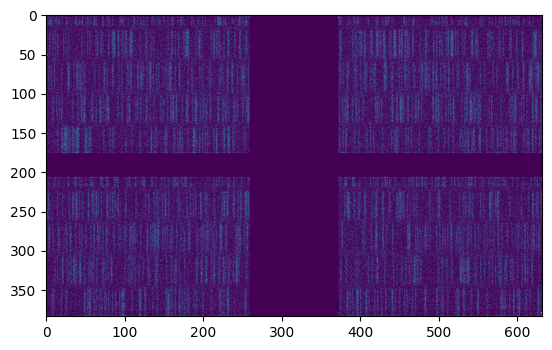

In [11]:
plt.imshow(detector_counts); plt.show()

## Reconstruction by cross-correlation

Once we have a detector image we can constructed a balanced reconstructed image with cross-correlation.

In [12]:
from bloodmoon import camera, simulation, count
from bloodmoon import decode

wfm = camera("wfm_mask.fits")
sdl = simulation("../../simulations/id00/")
detector, _ = count(wfm, sdl.reconstructed["cam1a"])

balanced = decode(wfm, detector)

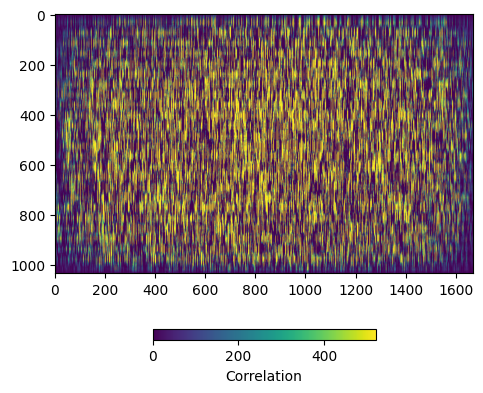

In [13]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(balanced, vmin=0, vmax=-balanced.min() / 10)
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", shrink=.45)
plt.show()

## Composing images from different cameras

Cool but not the coolest! Images from different camera can be recombined into a single picture.

In [14]:
from bloodmoon import camera, simulation, count, decode
from bloodmoon.images import compose

wfm = camera("wfm_mask.fits", upscale_x=5, upscale_y=8)
sdl = simulation("../../simulations/id00/")
detector_1a, _ = count(wfm, sdl.reconstructed["cam1a"])
detector_1b, _ = count(wfm, sdl.reconstructed["cam1b"])
balanced_1a = decode(wfm, detector_1a)
balanced_1b = decode(wfm, detector_1b)

composed, composed_f = compose(balanced_1a, balanced_1b)

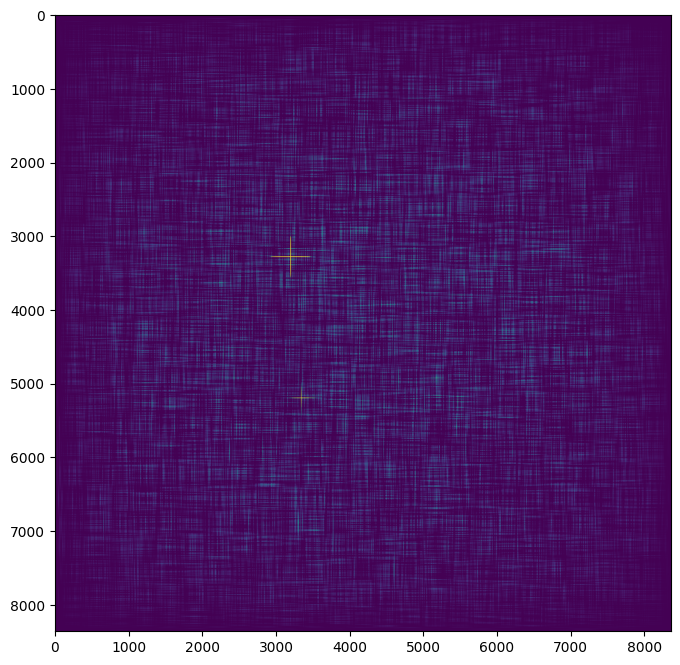

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=-composed.min())
plt.show()

Other than the recomposed array, `compose` returns a function mapping an index of the recomposed image to the associated indeces in its component images. In the next cell, we find the maximum of the composed image and map its value to individual cameras.

In [16]:
from bloodmoon.images import argmax

argmax_composed = argmax(composed)
argmax_1a, argmax_1b = composed_f(*argmax_composed)

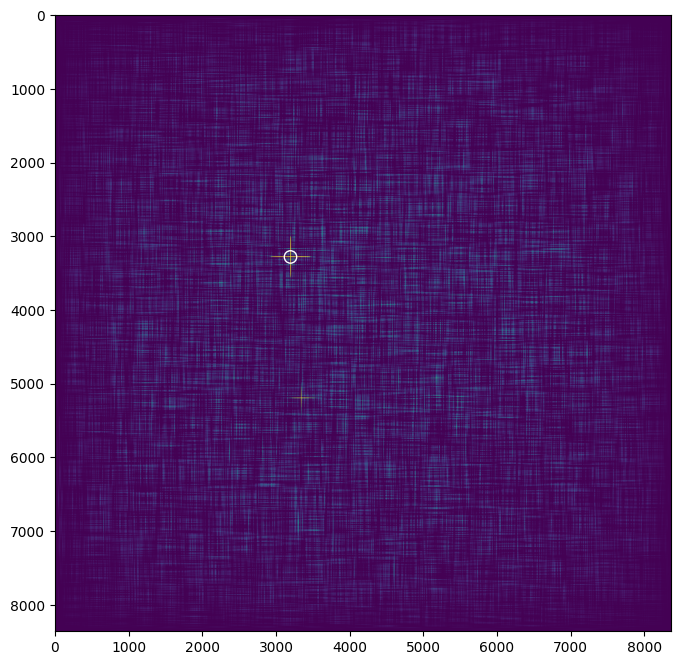

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=-composed.min())
ax.scatter(argmax_composed[1], argmax_composed[0], s=80, facecolors='none', edgecolors='white')
plt.show()

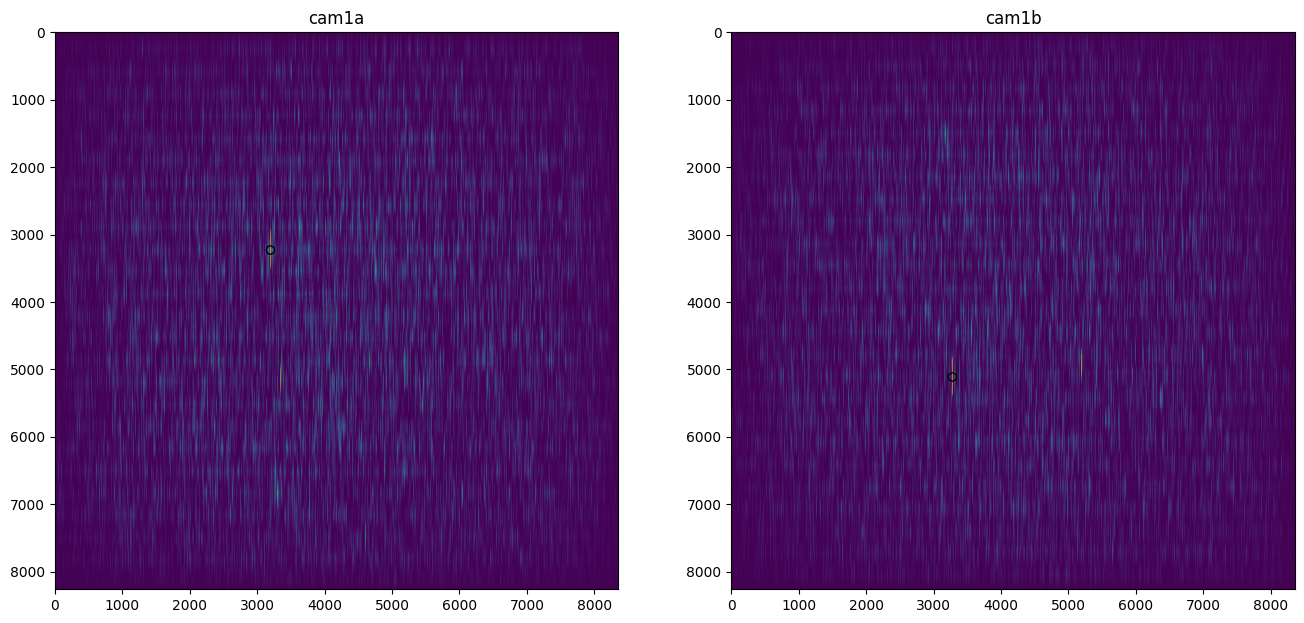

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
for ax, b, bmax, title in zip(
        axs,
        [balanced_1a, balanced_1b],
        [argmax_1a, argmax_1b],
        ["cam1a", "cam1b"],
):
    c0 = ax.imshow(b, vmin=0, vmax=-b.min())
    ax.scatter(bmax[1], bmax[0], facecolors='none', edgecolors='k')
    ax.set_title(title)
plt.show()

To obtain meaningful composed images, the detector pixels should be square. 
In turn, this requires the camera objects to be upscaled opportunely. Large upscaling are troublesome, because they results in much more memory and cpu loads. An alternative to working with upscaled images is to do most of the work at lower resolution, then resizing just for plotting purpose.

In [19]:
import numpy as np
from bloodmoon.images import upscale

arr = np.array([
    [1, 2],
    [3, 4],
])
# no magic here, `upscale` will just repeat elements along each dimension.
# note that, for compatibility, we use `x` and `y` and not `rows` and `cols`
upscale(arr, upscale_x=2, upscale_y=3)

array([[1, 1, 2, 2],
       [1, 1, 2, 2],
       [1, 1, 2, 2],
       [3, 3, 4, 4],
       [3, 3, 4, 4],
       [3, 3, 4, 4]])

## Simulating shadowgrams and sources

Constructing a realistic shadowgram is important for detecting and subtracting contributes from astrophysical sources. Bloodmoon exposes functions to generates shadowgrams with various degrees of realism. By default, simulated shadowgrams takes into account vignetting, the effect of detector reconstruction, and the fact that a source may fall at the intersection of multiple mask elements. 

In [20]:
from bloodmoon import camera
from bloodmoon import model_shadowgram

wfm = camera("wfm_mask.fits")
sg = model_shadowgram(wfm, shift_x=0., shift_y=0., fluence=1000)

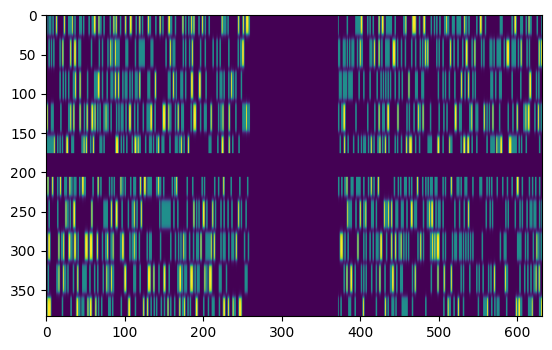

In [21]:
plt.imshow(sg); plt.show()

Shadowgrams sums are normalized to the fluence value:

In [22]:
f"Sum of shadowgram is {sg.sum():.1f}"

'Sum of shadowgram is 1000.0'

The effect of vignetting and detector reconstruction can be turned off.

In [23]:
sg = model_shadowgram(wfm, shift_x=0., shift_y=0., fluence=1000, vignetting=False, psfy=False)

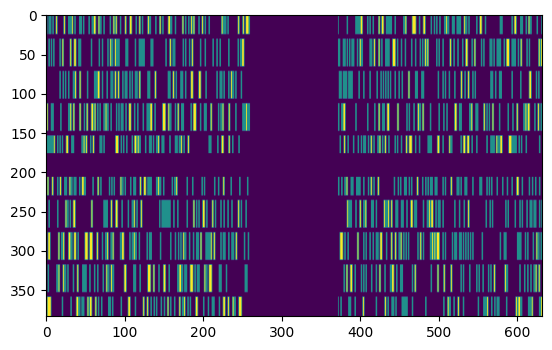

In [24]:
plt.imshow(sg); plt.show()

When generating a shadowgram, a source position is expressed in terms of "shifts". Shifts are defined as the displacement between the shadowgram and the detector center. Shifts are useful because they abstract away the distance between the mask and the detectors but in a future we will support more expressive ways of selecting a source direction.

In [25]:
sg = model_shadowgram(wfm, shift_x=150.02, shift_y=100.23, fluence=1000)

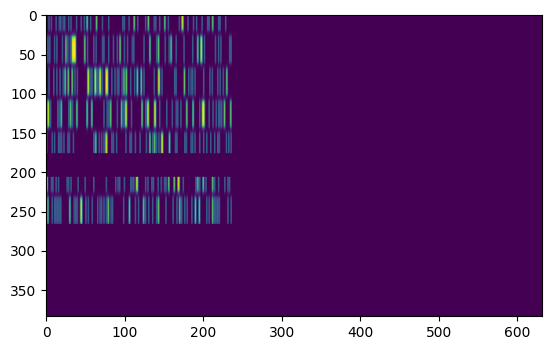

In [26]:
plt.imshow(sg); plt.show()  # remember imshow plots with graphics convention, i.e. y grows top to bottom.

A simulated sky image can be obtained either by manually decoding a shadowgram, or by using dedicated function 

In [27]:
from bloodmoon import camera
from bloodmoon import model_sky

wfm = camera("wfm_mask.fits")
sky = model_sky(wfm, shift_x=150.02, shift_y=100.23, fluence=1000)

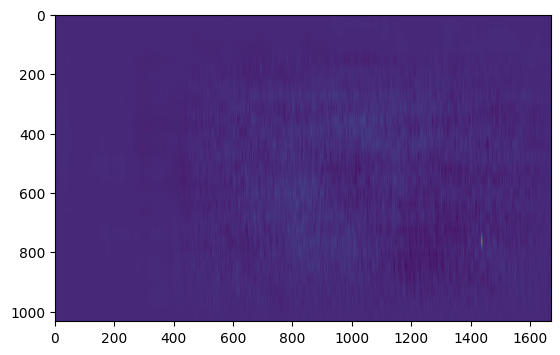

In [28]:
plt.imshow(sky); plt.show() 

## Fitting sources

Bloodmoon ships an optimizer function for estimating the direction and intensity of a source. The optimizer needs to be bootstrapped with a rough source location.

In [29]:
from bloodmoon import camera, model_sky
from bloodmoon.images import argmax
from bloodmoon import optimize

wfm = camera("wfm_mask.fits")
simulated_sky = model_sky(wfm, shift_x=13.02, shift_y=100.35, fluence=1000)

# note optimize takes matrix indices for arguments, but returns shifts.
shift_x, shift_y, fluence = optimize(wfm, simulated_sky, argmax(simulated_sky))
print(f"source direction: x= {shift_x:+.2f}, y= {shift_y:+.2f}, fluence= {fluence:2f}")

source direction: x= +13.02, y= +100.29, fluence= 819.176458


## Subtracting sources

The next is an example of how to subtract a strong source (Scorpius-X) from a simulation of the galactic center. This is the base of how iros works.

In [30]:
from bloodmoon import camera, simulation, decode, count, model_sky, optimize
from bloodmoon.images import argmax, compose, upscale

wfm = camera("wfm_mask.fits", upscale_x=5)
sdl = simulation("../../simulations/galcenter")

# computes detector images
detector_1a, _ = count(wfm, sdl.reconstructed["cam1a"])
detector_1b, _ = count(wfm, sdl.reconstructed["cam1b"])

# decode detector images using cross correlation
balanced_1a = decode(wfm, detector_1a)
balanced_1b = decode(wfm, detector_1b)

# fits most brilliant source position
source_1a = optimize(wfm, balanced_1a, argmax(balanced_1a))
source_1b = optimize(wfm, balanced_1b, argmax(balanced_1b))

# simulate source and subtract
residual_1a = balanced_1a - model_sky(wfm, *source_1a)
residual_1b = balanced_1b - model_sky(wfm, *source_1b)

# compose upscaled images for plotting
composed, _ = compose(
    upscale(balanced_1a, upscale_y=8),
    upscale(balanced_1b, upscale_y=8),
    strict=False,
)
composed_residuals, _ = compose(
    upscale(residual_1a, upscale_y=8),
    upscale(residual_1b, upscale_y=8),
    strict=False,
)

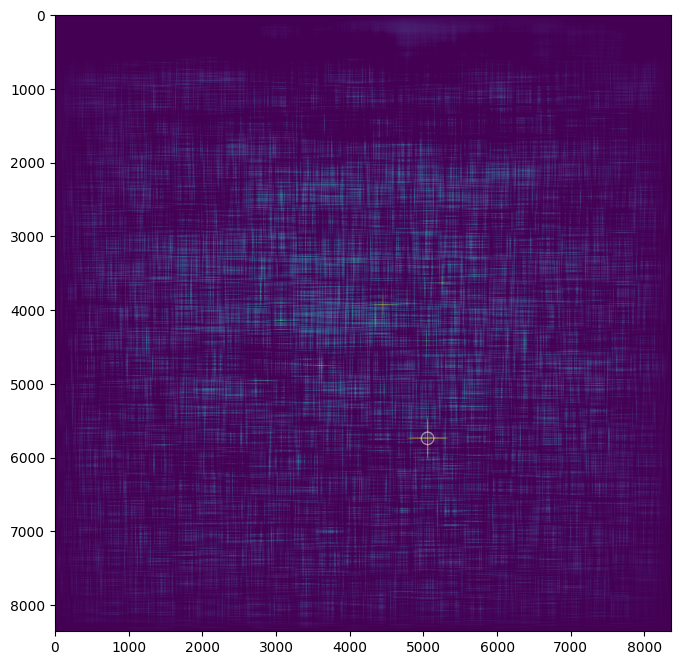

In [31]:
argmax_composed = argmax(composed)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=-composed.min())
ax.scatter(*argmax(composed)[::-1], s=80, facecolors='none', edgecolors='white', alpha=0.5)
plt.show()

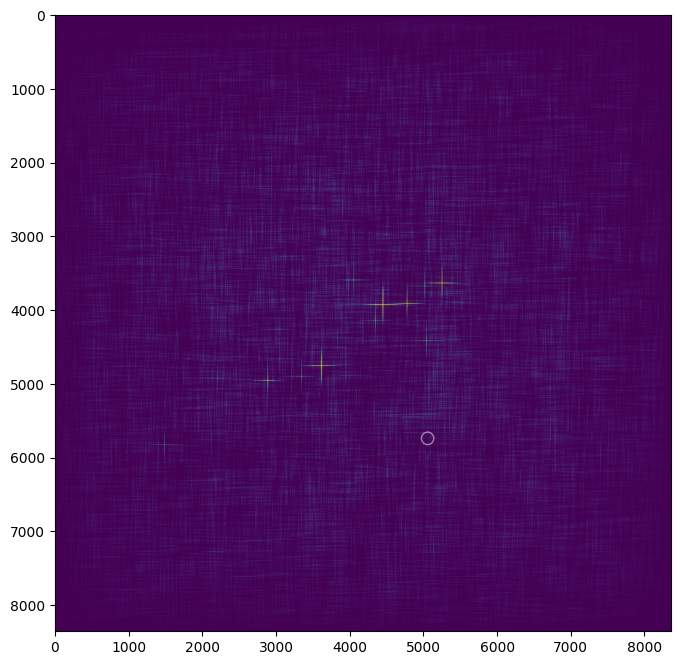

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed_residuals, vmin=0, vmax=-composed_residuals.min())
ax.scatter(*argmax(composed)[::-1], s=80, facecolors='none', edgecolors='white', alpha=0.5)
plt.show()

## Getting help

Bloodmoon is fairly documented. To get help for a function you can use either `?` or `help`. For example:

In [33]:
from bloodmoon import optimize

optimize?

Signature:
optimize(
    camera: bloodmoon.mask.CodedMaskCamera,
    sky: <built-in function array>,
    arg_sky: tuple[int, int],
    vignetting: bool = True,
    psfy: bool = True,
    verbose: bool = False,
) -> tuple[float, float, float]
Docstring:
Perform two-stage optimization to fit a point source model to sky image data.

This function performs a two-stage optimization:
1. Coarse optimization of fluence only, keeping position fixed
2. Fine, simultaneous optimization of position and fluence.
   This step is warm-started with the flux value inferred from the coarse step.

The process uses different model fidelities at each stage to balance
speed and accuracy.

Args:
    camera: CodedMaskCamera instance containing detector and mask parameters
    sky: 2D array of the reconstructed sky image to fit
    arg_sky: Initial guess for source position as (row, col) indices
    vignetting: If true, the model used for optimization will simulate vignetting.
    psfy: If true, the model used 